In [1]:
from gsd_lib import GSD, MinimalPackingGenerator
import numpy as np
from sigfig import round
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib widget


In [2]:
def round_to_n_significant_digits(value, n=3):
    if value == 0:
        return 0
    return np.round(value, -int(np.floor(np.log10(abs(value)))) + (n - 1))

vround = np.vectorize(round_to_n_significant_digits, otypes=[float])


In [3]:
# Data from Zeraati and Shamsabadi (2025)
zs_data = {
    "D": [
        50,
        70,
        105,
        175,
        50,
        70,
        105,
        175,
        70,
        105,
        175,
        70,
        105,
        175,
    ],
    "SF": [5, 5, 5, 5, 10, 10, 10, 10, 15, 15, 15, 20, 20, 20],
    "H": [24.4, 24.3, 23.6, 23.6, 24.8, 25.2, 24.4, 24.4, 25.6, 24.6, 24.1, 26.0, 24.8, 25.0],
    "e_c": [
        0.683,
        0.684,
        0.669,
        0.699,
        0.714,
        0.645,
        0.678,
        0.672,
        0.754,
        0.645,
        0.644,
        0.800,
        0.741,
        0.748,
    ],
    "N": [
        103075,
        202972,
        447161,
        1255067,
        12408,
        24349,
        54564,
        155028,
        7185,
        15719,
        44522,
        2816,
        6667,
        18180,
    ],
}

df = pd.DataFrame(zs_data)
df["sample_volume"] = np.pi * (df["D"] / 2) ** 2 * df["H"]
# df

In [4]:
# athabasca_sizes = np.array(
#     [
#         0.07647757992149977,
#         0.10668723256342968,
#         0.15160826983319625,
#         0.2521194933444675,
#         0.4270926409538863,
#         0.854529200202823,
#         2.36316461948315,
#     ]
# )
athabasca_sizes = np.array([0.076, 0.11, 0.15, 0.25, 0.43, 0.85, 2.40])
# athabasca_sizes = np.array([0.076, 0.11, 0.15, 0.25, 0.43, 0.85, 2.40, 4.50])
athabasca_sizes = np.insert(athabasca_sizes, 0, athabasca_sizes[0] / 2)
# athabasca_percent_passing = np.array([3.9, 5.14, 15.27, 60.13, 81.35, 93.40, 99.5, 100.00])
athabasca_percent_passing = np.array([3.86, 5.14, 15.27, 60.13, 81.35, 93.40, 100])
# athabasca_percent_passing = np.array(
#     [
#         3.879310344827573,
#         5.02873563218391,
#         15.229885057471265,
#         60.201149425287355,
#         81.4655172413793,
#         93.39080459770115,
#         99.56896551724138,
#     ]
# )
athabasca_percent_passing = np.insert(athabasca_percent_passing, 0, 0.0)
athabasca_retained = np.zeros(len(athabasca_sizes))
for i in range(len(athabasca_sizes) - 1):
    athabasca_retained[i] = (
        athabasca_percent_passing[i + 1] - athabasca_percent_passing[i]
    )
athabasca_retained = vround(athabasca_retained, 2)



In [5]:
df["G"] = [GSD(sizes=athabasca_sizes*sf, masses=athabasca_retained) for sf in df["SF"]]
df["MDM"] = [
    MinimalPackingGenerator(gsd, x_n_factor=0.5, tol=1e-2, flex=True).mps
    for gsd in df["G"]
]
df["N_mdm"] = [sum(mdm.quantities) for mdm in df["MDM"]]
df["V_solids_mdm"] = [mdm.total_volume for mdm in df["MDM"]]
df["V_total_mdm"] = df["V_solids_mdm"] * (1 + df["e_c"])
df["MDM_per_sample"] = df["sample_volume"] / df["V_total_mdm"]
df["N_predicted"] = df["N_mdm"] * df["MDM_per_sample"]
df["USCS_name"] = [g.uscs_name for g in df["G"]]

unscaled_df = pd.DataFrame({"D": [50, 70, 105, 175]})
unscaled_df["G"] = [GSD(sizes=athabasca_sizes, masses=athabasca_retained) for _ in range(4)]
unscaled_df["MDM"] = [
    MinimalPackingGenerator(gsd, x_n_factor=0.5, tol=1e-2, flex=True).mps
    for gsd in unscaled_df["G"]
]
unscaled_df["N_mdm"] = [sum(mdm.quantities) for mdm in unscaled_df["MDM"]]
unscaled_df["V_solids_mdm"] = [mdm.total_volume for mdm in unscaled_df["MDM"]]
unscaled_df["V_total_mdm"] = unscaled_df["V_solids_mdm"] * (1 + 0.67)
unscaled_df["MDM_per_sample"] = (25 * np.pi * (unscaled_df["D"] / 2) ** 2) / unscaled_df["V_total_mdm"]
unscaled_df["N_predicted"] = unscaled_df["N_mdm"] * unscaled_df["MDM_per_sample"]
unscaled_df["USCS_name"] = [g.uscs_name for g in unscaled_df["G"]]

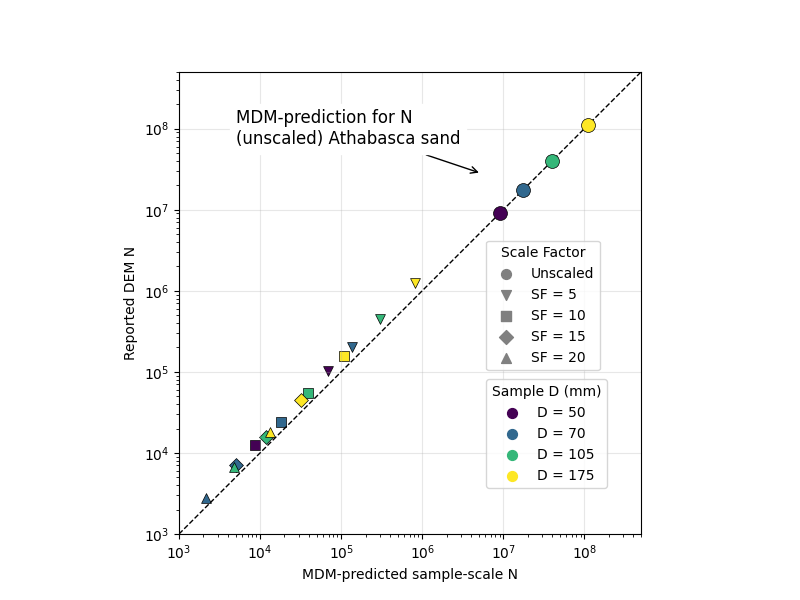

In [6]:
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

markers = ["v", "s", "D", "^"]
colors = plt.cm.viridis(
    np.linspace(0, 1, len(df["D"].unique()))
)  # Color map for D values

# Create a mapping for SF values to markers
sf_values = sorted(df["SF"].unique())
sf_to_marker = {sf: markers[i % len(markers)] for i, sf in enumerate(sf_values)}
# Add SF=1 for unscaled data
sf_to_marker[1] = "o"  # Use 'x' marker for SF=1 (unscaled)

# Create a mapping for D values to colors
d_values = sorted(df["D"].unique())
d_to_color = {d: colors[i] for i, d in enumerate(d_values)}

# Plot scaled data
for _, row in df.iterrows():
    ax.scatter(
        row["N_predicted"],
        row["N"],
        s=50,
        marker=sf_to_marker[row["SF"]],
        color=d_to_color[row["D"]],
        alpha=1,
        edgecolors="black",
        linewidth=0.5,
    )

# Plot unscaled data with same color scheme
for _, row in unscaled_df.iterrows():
    ax.scatter(
        row["N_predicted"],
        row["N_predicted"],  # or use actual N if available
        s=100,
        marker=sf_to_marker[1],  # Use SF=1 marker
        color=d_to_color[row["D"]],
        alpha=1,
        edgecolors="black",
        linewidth=0.5,
        zorder=5
    )

arrowprops = dict(arrowstyle="->", color="k", lw=1)
bbox = dict(fc="1", ec="1")

ax.annotate(
    "MDM-prediction for N\n(unscaled) Athabasca sand",
    xy=(5.4e6, 2.8e7),
    xytext=(5e3, 1e8),
    fontsize=12,
    arrowprops=arrowprops,
    bbox=bbox,
    color="k",
    ha="left",
    va="center",
)


# Create custom legend for markers (SF values including unscaled)
all_sf_values = sorted(list(sf_values) + [1])  # Include SF=1
marker_legend_elements = [
    plt.scatter(
        [],
        [],
        marker=sf_to_marker[sf],
        color="gray",
        s=50,
        label=f"SF = {sf}" if sf != 1 else "Unscaled",
    )
    for sf in all_sf_values
]

# Create custom legend for colors (D values)
color_legend_elements = [
    plt.scatter([], [], marker="o", color=d_to_color[d], s=50, label=f"D = {d}")
    for d in d_values
]

# Add y=x line
ax.plot([1e3, 5e8], [1e3, 5e8], color="k", linestyle="--", linewidth=1)

# Add legends
legend1 = ax.legend(
    handles=marker_legend_elements,
    title="Scale Factor",
    loc="upper left",
    bbox_to_anchor=(0.65, 0.65),
)
legend2 = ax.legend(
    handles=color_legend_elements,
    title="Sample D (mm)",
    loc="upper left",
    bbox_to_anchor=(0.65, 0.35),
)
ax.add_artist(legend1)  # Keep both legends

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([1e3, 5e8])
ax.set_ylim([1e3, 5e8])
ax.set_aspect('equal')  # Ensure equal scaling of axes
ax.set_xlabel("MDM-predicted sample-scale N")
ax.set_ylabel("Reported DEM N")
ax.grid(True, alpha=0.3)


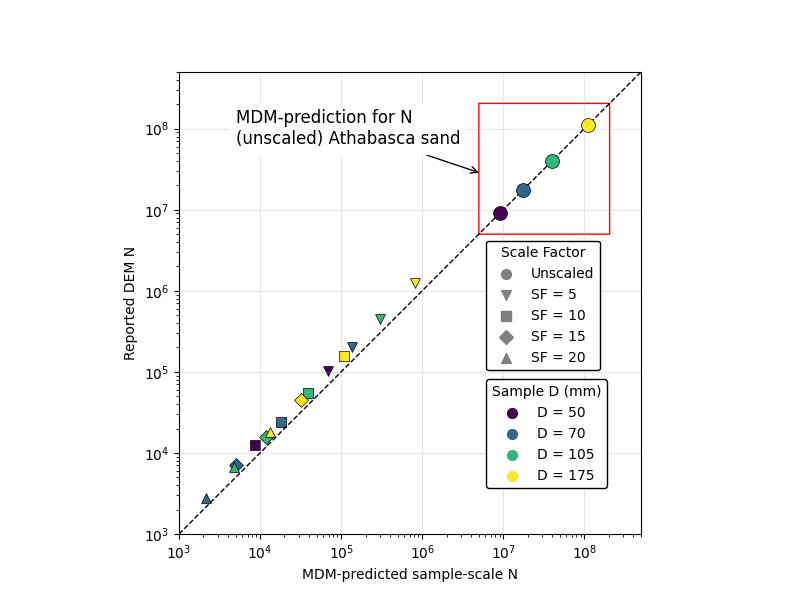

In [18]:
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

markers = ["v", "s", "D", "^"]
colors = plt.cm.viridis(
    np.linspace(0, 1, len(df["D"].unique()))
)  # Color map for D values

# Create a mapping for SF values to markers
sf_values = sorted(df["SF"].unique())
sf_to_marker = {sf: markers[i % len(markers)] for i, sf in enumerate(sf_values)}
# Add SF=1 for unscaled data
sf_to_marker[1] = "o"  # Use 'x' marker for SF=1 (unscaled)

# Create a mapping for D values to colors
d_values = sorted(df["D"].unique())
d_to_color = {d: colors[i] for i, d in enumerate(d_values)}

# Plot scaled data
for _, row in df.iterrows():
    ax.scatter(
        row["N_predicted"],
        row["N"],
        s=50,
        marker=sf_to_marker[row["SF"]],
        color=d_to_color[row["D"]],
        alpha=1,
        edgecolors="black",
        linewidth=0.5,
    )

# Plot unscaled data with same color scheme
unscaled_x = []
unscaled_y = []
for _, row in unscaled_df.iterrows():
    ax.scatter(
        row["N_predicted"],
        row["N_predicted"],  # or use actual N if available
        s=100,
        marker=sf_to_marker[1],  # Use SF=1 marker
        color=d_to_color[row["D"]],
        alpha=1,
        edgecolors="black",
        linewidth=0.5,
        zorder=5,
    )
    unscaled_x.append(row["N_predicted"])
    unscaled_y.append(row["N_predicted"])

# Add rectangle around prediction
from matplotlib.patches import FancyBboxPatch

# Create rectangle around prediction
box = FancyBboxPatch(
    (5e6, 5e6),
    width=2e8,
    height=2e8,
    boxstyle="round",
    # linewidth=2,
    edgecolor="red",
    facecolor="none",
    # linestyle="--",
    # alpha=0.8,
)

ax.add_patch(box)

# ...rest of your existing code...
arrowprops = dict(arrowstyle="->", color="k", lw=1)
bbox = dict(fc="1", ec="1")

ax.annotate(
    "MDM-prediction for N\n(unscaled) Athabasca sand",
    xy=(5.4e6, 2.8e7),
    xytext=(5e3, 1e8),
    fontsize=12,
    arrowprops=arrowprops,
    bbox=bbox,
    color="k",
    ha="left",
    va="center",
)

# Create custom legend for markers (SF values including unscaled)
all_sf_values = sorted(list(sf_values) + [1])  # Include SF=1
marker_legend_elements = [
    plt.scatter(
        [],
        [],
        marker=sf_to_marker[sf],
        color="gray",
        s=50,
        label=f"SF = {sf}" if sf != 1 else "Unscaled",
    )
    for sf in all_sf_values
]

# Create custom legend for colors (D values)
color_legend_elements = [
    plt.scatter([], [], marker="o", color=d_to_color[d], s=50, label=f"D = {d}")
    for d in d_values
]

# Add y=x line
ax.plot([1e3, 5e8], [1e3, 5e8], color="k", linestyle="--", linewidth=1)

# Add legends
legend1 = ax.legend(
    handles=marker_legend_elements,
    title="Scale Factor",
    loc="upper left",
    bbox_to_anchor=(0.65, 0.65),
    framealpha=1,
    edgecolor="0",
)
legend2 = ax.legend(
    handles=color_legend_elements,
    title="Sample D (mm)",
    loc="upper left",
    bbox_to_anchor=(0.65, 0.35),
    framealpha=1,
    edgecolor="0",
)
ax.add_artist(legend1)  # Keep both legends

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([1e3, 5e8])
ax.set_ylim([1e3, 5e8])
ax.set_aspect("equal")  # Ensure equal scaling of axes
ax.set_xlabel("MDM-predicted sample-scale N")
ax.set_ylabel("Reported DEM N")
ax.grid(True, alpha=0.3)


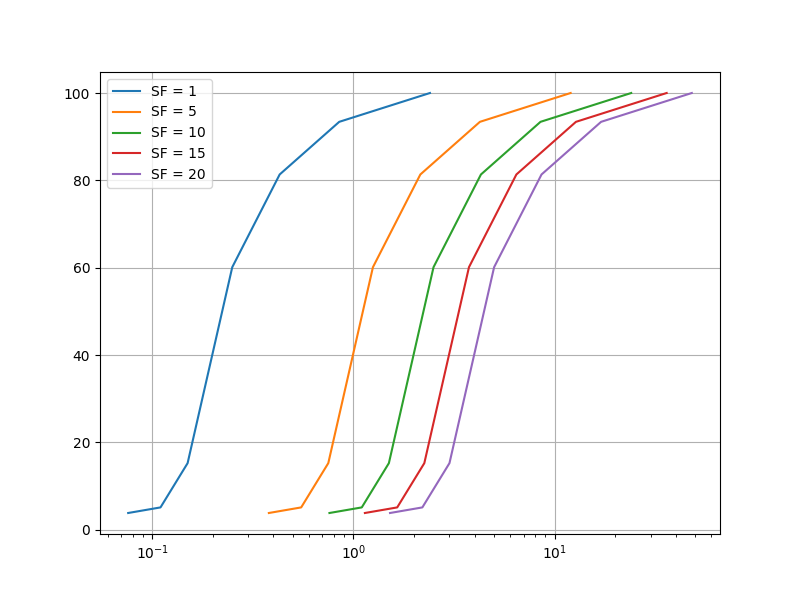

In [8]:
SF = [1, 5, 10, 15, 20]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for sf in SF:
    ax.plot(
        athabasca_sizes[1:] * sf,
        athabasca_percent_passing[1:],
        label=f"SF = {sf}")
ax.set_xscale("log")
ax.legend()
ax.grid()

In [9]:
gsds = [GSD(sizes=athabasca_sizes*sf, masses=athabasca_retained) for sf in SF]
mdms = [MinimalPackingGenerator(gsd, x_n_factor=0.5, tol=1e-2, flex=True).mps for gsd in gsds]

In [10]:
sample_d = 105 #np.array([50, 70, 105, 175])
sample_height = 25
sample_volume = np.pi * (sample_d / 2) ** 2 * sample_height  # (4/np.pi) *
void_ratio = 0.4
sample_volume

216475.36878642166

In [11]:
for i, gsd in enumerate(gsds):
    print(f"SF = {SF[i]}")
    # print(f"Sizes in gsd: {gsd.sizes}")
    # print(f"Masses in gsd: {gsd.masses}")
    print(f"Sizes in mdm: {mdms[i].sizes}")
    print(f"Q_mdm = {mdms[i].quantities}")
    # # print(f"Minimum size in gsd: {gsd.sizes[0]}")
    # # print(f"Maximum size in gsd: {gsd.sizes[-1]}")
    # # print(f"Minimum size in mdm: {mdms[i].sizes[0]}")
    # # print(f"Maximum size in mdm: {mdms[i].sizes[-1]}")
    print(f"N_mdm = {round_to_n_significant_digits(sum(mdms[i].quantities))}")
    # print(f"V_mdm = {round_to_n_significant_digits(mdms[i].total_volume, 3)}")
    print(f"MDMs per sample volume = {round_to_n_significant_digits(sample_volume/(mdms[i].total_volume*(1+void_ratio)), 3)}")
    print(f"N_sample = {round_to_n_significant_digits(sample_volume/(mdms[i].total_volume*(1+void_ratio)) * sum(mdms[i].quantities))}")

    # 0.038 0.076 0.11  0.15  0.25  0.43  0.85  2.4

SF = 1
Sizes in mdm: [0.07599636 0.10994297 0.14998396 0.24997522 0.42976958 0.84349922
 1.625     ]
Q_mdm = [5777  636 1927 1873  172   13    1]
N_mdm = 10400
MDMs per sample volume = 4550.0
N_sample = 47300000.0
SF = 5
Sizes in mdm: [0.37998181 0.54971485 0.7499198  1.24987612 2.14884789 4.21749609
 8.125     ]
Q_mdm = [5777  636 1927 1873  172   13    1]
N_mdm = 10400
MDMs per sample volume = 36.4
N_sample = 379000.0
SF = 10
Sizes in mdm: [ 0.75996362  1.0994297   1.4998396   2.49975224  4.29769577  8.43499219
 16.25      ]
Q_mdm = [5777  636 1927 1873  172   13    1]
N_mdm = 10400
MDMs per sample volume = 4.55
N_sample = 47300.0
SF = 15
Sizes in mdm: [ 1.13994542  1.64914455  2.2497594   3.74962835  6.44654366 12.65248828
 24.375     ]
Q_mdm = [5777  636 1927 1873  172   13    1]
N_mdm = 10400
MDMs per sample volume = 1.35
N_sample = 14000.0
SF = 20
Sizes in mdm: [ 1.51992723  2.1988594   2.99967919  4.99950447  8.59539155 16.86998438
 32.5       ]
Q_mdm = [5777  636 1927 1873  172